## 1. Setup and Data Loading

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

In [3]:
# Define file paths
BASE_DIR = Path('baseline_results')
LLM_RESULTS_FILE = BASE_DIR / 'llm_results.json'
EVAL_RESULTS_FILE = BASE_DIR / 'evaluation_results_10_combined.json'
TFIDF_BM25_FILE = BASE_DIR / 'tfidf_bm25_lead_results.json'

# Load all results files
print("Loading data files...")

with open(LLM_RESULTS_FILE, 'r') as f:
    llm_results = json.load(f)
print(f"✓ Loaded LLM results: {len(llm_results)} papers")

with open(EVAL_RESULTS_FILE, 'r') as f:
    eval_results = json.load(f)
print(f"✓ Loaded evaluation results: {len(eval_results)} papers")

with open(TFIDF_BM25_FILE, 'r') as f:
    tfidf_bm25_results = json.load(f)
print(f"✓ Loaded TF-IDF/BM25/Lead results: {len(tfidf_bm25_results)} papers")

print("\n" + "="*60)
print("Data loading complete!")
print("="*60)

Loading data files...
✓ Loaded LLM results: 10 papers
✓ Loaded evaluation results: 10 papers
✓ Loaded TF-IDF/BM25/Lead results: 10 papers

Data loading complete!


## 2. Data Consolidation

Consolidate all results into structured DataFrames for analysis.

In [4]:
def create_consolidated_dataframe():
    """
    Create a consolidated DataFrame with all baseline results.
    """
    rows = []
    
    # Process LLM results (gemma3:1b)
    for paper in llm_results:
        paper_id = paper['paper_id']
        if 'gemma3:1b' in paper:
            metrics = paper['gemma3:1b']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'LLM-Gemma3-1B',
                'category': 'LLM-Based',
                'rouge1': metrics.get('rouge1', np.nan),
                'rouge2': metrics.get('rouge2', np.nan),
                'rougeL': metrics.get('rougeL', np.nan),
                'bertscore_f1': metrics.get('bertscore_f1', np.nan),
                # 'similarity_to_abstract': metrics.get('similarity_to_abstract', np.nan)
            })
    
    # Process evaluation results (embedding-based + other LLMs)
    for paper in eval_results:
        paper_id = paper['paper_id']
        
        # Gemini-2.5-Flash
        if 'gemini-2.5-flash' in paper:
            metrics = paper['gemini-2.5-flash']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'Embedding-Gemini-2.5',
                'category': 'Embedding-Based',
                'rouge1': metrics.get('rouge1', np.nan),
                'rouge2': metrics.get('rouge2', np.nan),
                'rougeL': metrics.get('rougeL', np.nan),
                'bertscore_f1': metrics.get('bertscore_f1', np.nan),
                # 'similarity_to_abstract': metrics.get('similarity_to_abstract', np.nan)
            })
        
        # Llama-3.1-8B
        if 'llama-3.1-8b-instant' in paper:
            metrics = paper['llama-3.1-8b-instant']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'Embedding-Llama-3.1',
                'category': 'Embedding-Based',
                'rouge1': metrics.get('rouge1', np.nan),
                'rouge2': metrics.get('rouge2', np.nan),
                'rougeL': metrics.get('rougeL', np.nan),
                'bertscore_f1': metrics.get('bertscore_f1', np.nan),
                # 'similarity_to_abstract': metrics.get('similarity_to_abstract', np.nan)
            })
        
        # LED
        if 'led' in paper:
            metrics = paper['led']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'Embedding-LED',
                'category': 'Embedding-Based',
                'rouge1': metrics.get('rouge1', np.nan),
                'rouge2': metrics.get('rouge2', np.nan),
                'rougeL': metrics.get('rougeL', np.nan),
                'bertscore_f1': metrics.get('bertscore_f1', np.nan),
                # 'similarity_to_abstract': metrics.get('similarity_to_abstract', np.nan)
            })
    
    # Process TF-IDF/BM25/Lead-N results
    for paper_id, content in tfidf_bm25_results.items():
        scores = content['score']
        lead_n = scores['lead_n']

        # TF-IDF
        if 'TF-IDF' in scores:
            tfidf = scores['TF-IDF']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'TF-IDF',
                'category': 'Stats-Based',
                'rouge1': tfidf.get('rouge1', np.nan),
                'rouge2': tfidf.get('rouge2', np.nan),
                'rougeL': tfidf.get('rougeL', np.nan),
                'bertscore_f1': tfidf.get('bertscore_f1', np.nan),
            })
        
        # BM25
        if 'BM25' in scores:
            bm25 = scores['BM25']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'BM25',
                'category': 'Stats-Based',
                'rouge1': bm25.get('rouge1', np.nan),
                'rouge2': bm25.get('rouge2', np.nan),
                'rougeL': bm25.get('rougeL', np.nan),
                'bertscore_f1': bm25.get('bertscore_f1', np.nan),
            })
        
        # Lead-N
        if 'lead_n' in scores:
            lead_n = scores['lead_n']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'Lead-N',
                'category': 'Rules-Based',
                'rouge1': lead_n.get('rouge1', np.nan),
                'rouge2': lead_n.get('rouge2', np.nan),
                'rougeL': lead_n.get('rougeL', np.nan),
                'bertscore_f1': lead_n.get('bertscore_f1', np.nan),
            })

        if 'lead_n_by_section' in scores:
            lead_n_by_section = scores['lead_n_by_section']
            rows.append({
                'paper_id': paper_id,
                'baseline': 'Lead-N-By-Section',
                'category': 'Rules-Based',
                'rouge1': lead_n_by_section.get('rouge1', np.nan),
                'rouge2': lead_n_by_section.get('rouge2', np.nan),
                'rougeL': lead_n_by_section.get('rougeL', np.nan),
                'bertscore_f1': lead_n_by_section.get('bertscore_f1', np.nan),
            })
    
    df = pd.DataFrame(rows)
    return df

# Create consolidated DataFrame
df_consolidated = create_consolidated_dataframe()

print(f"✓ Consolidated DataFrame created with {len(df_consolidated)} entries")
print(f"\nBaselines included: {df_consolidated['baseline'].unique().tolist()}")
print(f"\nCategories: {df_consolidated['category'].unique().tolist()}")

✓ Consolidated DataFrame created with 80 entries

Baselines included: ['LLM-Gemma3-1B', 'Embedding-Gemini-2.5', 'Embedding-Llama-3.1', 'Embedding-LED', 'TF-IDF', 'BM25', 'Lead-N', 'Lead-N-By-Section']

Categories: ['LLM-Based', 'Embedding-Based', 'Stats-Based', 'Rules-Based']


In [5]:
# Display first few rows
print("\nFirst 10 rows of consolidated data:")
df_consolidated


First 10 rows of consolidated data:


,paper_id,baseline,category,rouge1,rouge2,rougeL,bertscore_f1
0,2511.21398v1,LLM-Gemma3-1B,LLM-Based,0.4169,0.0000,0.1694,0.6608
1,2511.21444v1,LLM-Gemma3-1B,LLM-Based,0.3631,0.0000,0.1600,0.6087
2,2511.21460v1,LLM-Gemma3-1B,LLM-Based,0.4299,0.0000,0.1620,0.6448
3,2511.21471v1,LLM-Gemma3-1B,LLM-Based,0.3537,0.0000,0.1801,0.6063
4,2511.21522v1,LLM-Gemma3-1B,LLM-Based,0.2980,0.0000,0.1804,0.5986
5,2511.21569v1,LLM-Gemma3-1B,LLM-Based,0.1744,0.0000,0.1128,0.5627
6,2511.21570v1,LLM-Gemma3-1B,LLM-Based,0.2437,0.0000,0.1290,0.6054
7,2511.21591v1,LLM-Gemma3-1B,LLM-Based,0.3357,0.0000,0.1888,0.5941
8,2511.21636v1,LLM-Gemma3-1B,LLM-Based,0.3010,0.0000,0.1538,0.5590
9,2511.21678v1,LLM-Gemma3-1B,LLM-Based,0.3614,0.0000,0.1682,0.6169


In [6]:
# Data quality check
print("Data Quality Summary:")
print("="*60)
print(f"Total entries: {len(df_consolidated)}")
print(f"Unique papers: {df_consolidated['paper_id'].nunique()}")
print(f"\nMissing values per column:")
print(df_consolidated.isnull().sum())
print(f"\nBaseline distribution:")
print(df_consolidated['baseline'].value_counts())

Data Quality Summary:
Total entries: 80
Unique papers: 10

Missing values per column:
paper_id        0
baseline        0
category        0
rouge1          0
rouge2          0
rougeL          0
bertscore_f1    0
dtype: int64

Baseline distribution:
baseline
LLM-Gemma3-1B           10
Embedding-Gemini-2.5    10
Embedding-Llama-3.1     10
Embedding-LED           10
TF-IDF                  10
BM25                    10
Lead-N                  10
Lead-N-By-Section       10
Name: count, dtype: int64


## 3. Descriptive Statistics

In [7]:
# Calculate summary statistics by baseline
summary_stats = df_consolidated.groupby('baseline')[[
    'rouge1', 'rouge2', 'rougeL', 'bertscore_f1',
]].agg(['mean', 'std', 'min', 'max', 'median'])

print("\n" + "="*80)
print("SUMMARY STATISTICS BY BASELINE")
print("="*80)
summary_stats


SUMMARY STATISTICS BY BASELINE


rouge1                             rouge2                \
                       mean    std    min    max median   mean    std    min   
baseline                                                                       
BM25                 0.3178 0.1218 0.1430 0.4787 0.3427 0.0701 0.0463 0.0040   
Embedding-Gemini-2.5 0.4106 0.1062 0.1507 0.5167 0.4412 0.1049 0.0370 0.0276   
Embedding-LED        0.3408 0.1041 0.0980 0.4482 0.3527 0.0788 0.0368 0.0123   
Embedding-Llama-3.1  0.3897 0.0880 0.1897 0.4692 0.4168 0.0969 0.0373 0.0239   
LLM-Gemma3-1B        0.3278 0.0772 0.1744 0.4299 0.3447 0.0000 0.0000 0.0000   
Lead-N               0.2955 0.0493 0.1987 0.3578 0.3108 0.0544 0.0181 0.0240   
Lead-N-By-Section    0.3344 0.0993 0.0958 0.4160 0.3757 0.0885 0.0292 0.0192   
TF-IDF               0.3618 0.0721 0.2105 0.4650 0.3671 0.0918 0.0266 0.0357   

                                   rougeL                              \
                        max median   mean    std    min    max median   
baseline                                                                
BM25                 0.1316 0.0840 0.1455 0.0462 0.0644 0.2150 0.1488   
Embedding-Gemini-2.5 0.1464 0.1095 0.1861 0.0602 0.0685 0.2750 0.1921   
Embedding-LED        0.1257 0.0865 0.1463 0.0450 0.0490 0.2129 0.1584   
Embedding-Llama-3.1  0.1397 0.1031 0.1839 0.0405 0.1028 0.2386 0.1921   
LLM-Gemma3-1B        0.0000 0.0000 0.1605 0.0236 0.1128 0.1888 0.1651   
Lead-N               0.0772 0.0554 0.1398 0.0217 0.1105 0.1725 0.1393   
Lead-N-By-Section    0.1206 0.0911 0.1573 0.0507 0.0465 0.2080 0.1687   
TF-IDF               0.1278 0.0996 0.1678 0.0323 0.1147 0.2140 0.1746   

                     bertscore_f1                              
                             mean    std    min    max median  
baseline                                                       
BM25                       0.7441 0.0767 0.6160 0.8202 0.7709  
Embedding-Gemini-2.5       0.7886 0.0351 0.7229 0.8348 0.7935  
Embedding-LED              0.7894 0.0296 0.7322 0.8251 0.7973  
Embedding-Llama-3.1        0.7898 0.0297 0.7198 0.8116 0.8020  
LLM-Gemma3-1B              0.6057 0.0315 0.5590 0.6608 0.6059  
Lead-N                     0.7652 0.0220 0.7297 0.8002 0.7605  
Lead-N-By-Section          0.7845 0.0208 0.7398 0.8070 0.7887  
TF-IDF                     0.7817 0.0466 0.6591 0.8214 0.7876

In [8]:
# Calculate summary statistics by category
category_stats = df_consolidated.groupby('category')[[
    'rouge1', 'rouge2', 'rougeL', 'bertscore_f1'
]].agg(['mean', 'std'])

print("\n" + "="*80)
print("SUMMARY STATISTICS BY CATEGORY")
print("="*80)
category_stats


SUMMARY STATISTICS BY CATEGORY


rouge1        rouge2        rougeL        bertscore_f1       
                  mean    std   mean    std   mean    std         mean    std
category                                                                     
Embedding-Based 0.3804 0.1007 0.0936 0.0374 0.1721 0.0510       0.7893 0.0305
LLM-Based       0.3278 0.0772 0.0000 0.0000 0.1605 0.0236       0.6057 0.0315
Rules-Based     0.3149 0.0789 0.0715 0.0294 0.1486 0.0390       0.7749 0.0231
Stats-Based     0.3398 0.1000 0.0809 0.0384 0.1567 0.0404       0.7629 0.0647

### Observation
From the above given table we can see that the Embedding based category has a higher score for the most part, The direct successor to it would be Stats-Based category, we will try to visualize the information better with plots to understand the behaviour and to understand the baselines in general.

## 4. Comparative Visualizations

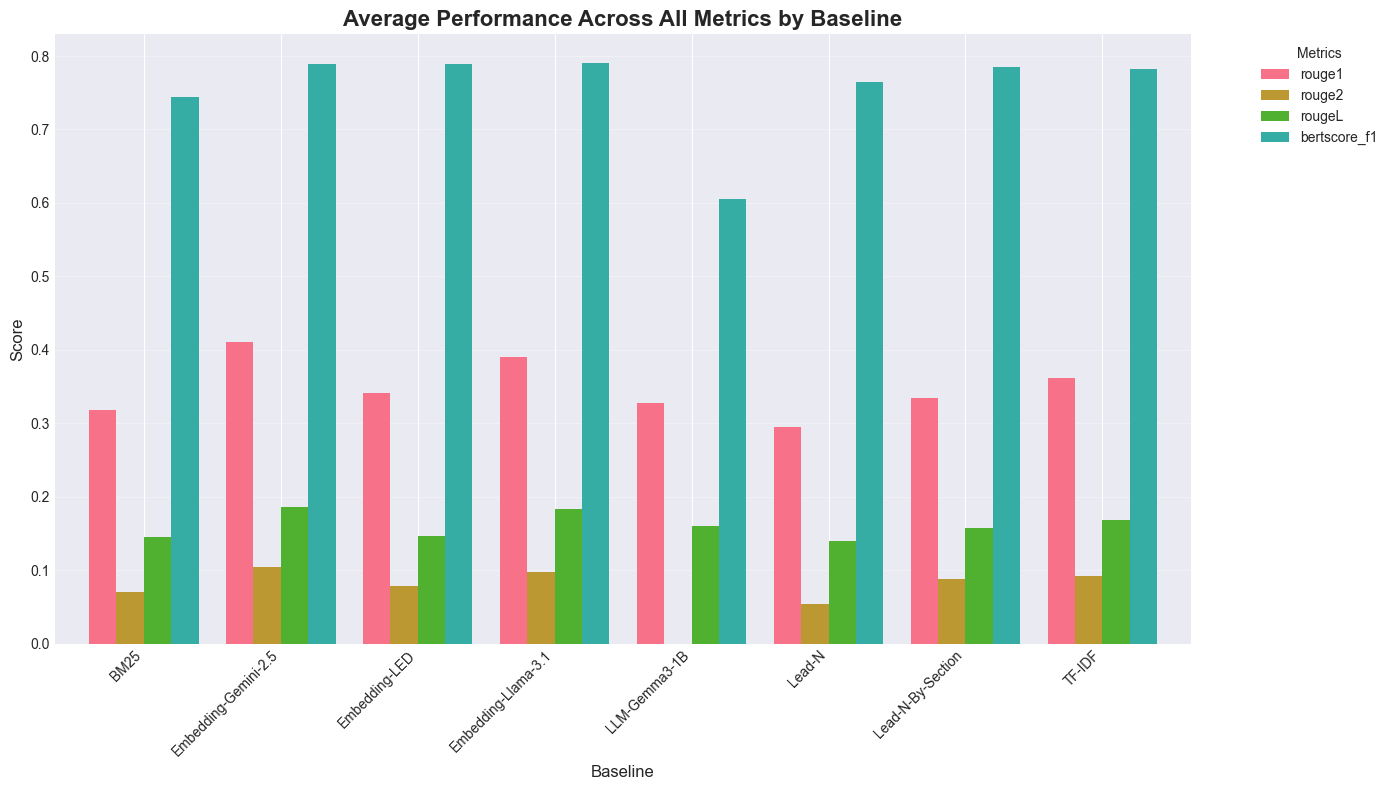

In [9]:
# Average performance across all metrics by baseline
metrics = ['rouge1', 'rouge2', 'rougeL', 'bertscore_f1']
avg_performance = df_consolidated.groupby('baseline')[metrics].mean()

fig, ax = plt.subplots(figsize=(14, 8))
avg_performance.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Average Performance Across All Metrics by Baseline', fontsize=16, fontweight='bold')
ax.set_xlabel('Baseline', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Observation
In the plot above, we have showed all the baseline performances, interestingly, if we take a closer look into the embedding categories, we have taken 3 models into account : 
1. Gemini-2.5-flash
2. llama-3.1-8b-instant
3. led-large-book-summary

Despite Gemini-2.5-flash being a larger model and with the expectation of it being able to perform better, it really doesn't contribute any differently compared to the other 2 models. All the models hold up quite toe-to-toe especially in terms of bertscore_f1.

Overall Performance Hierarchy:
- embedding based approaches
- stats-based methods
- rules based approaches
- llm based apporach

#### Insights
- High BERTScore but low ROUGE scores suggest that while summaries capture semantic meaning well, they use different wording than the reference abstracts.
- The gap between stats-based methods and embedding-based approaches is relatively modest, suggesting diminishing returns from increased complexity
- Rule based approaches perform competitively with more complex methods

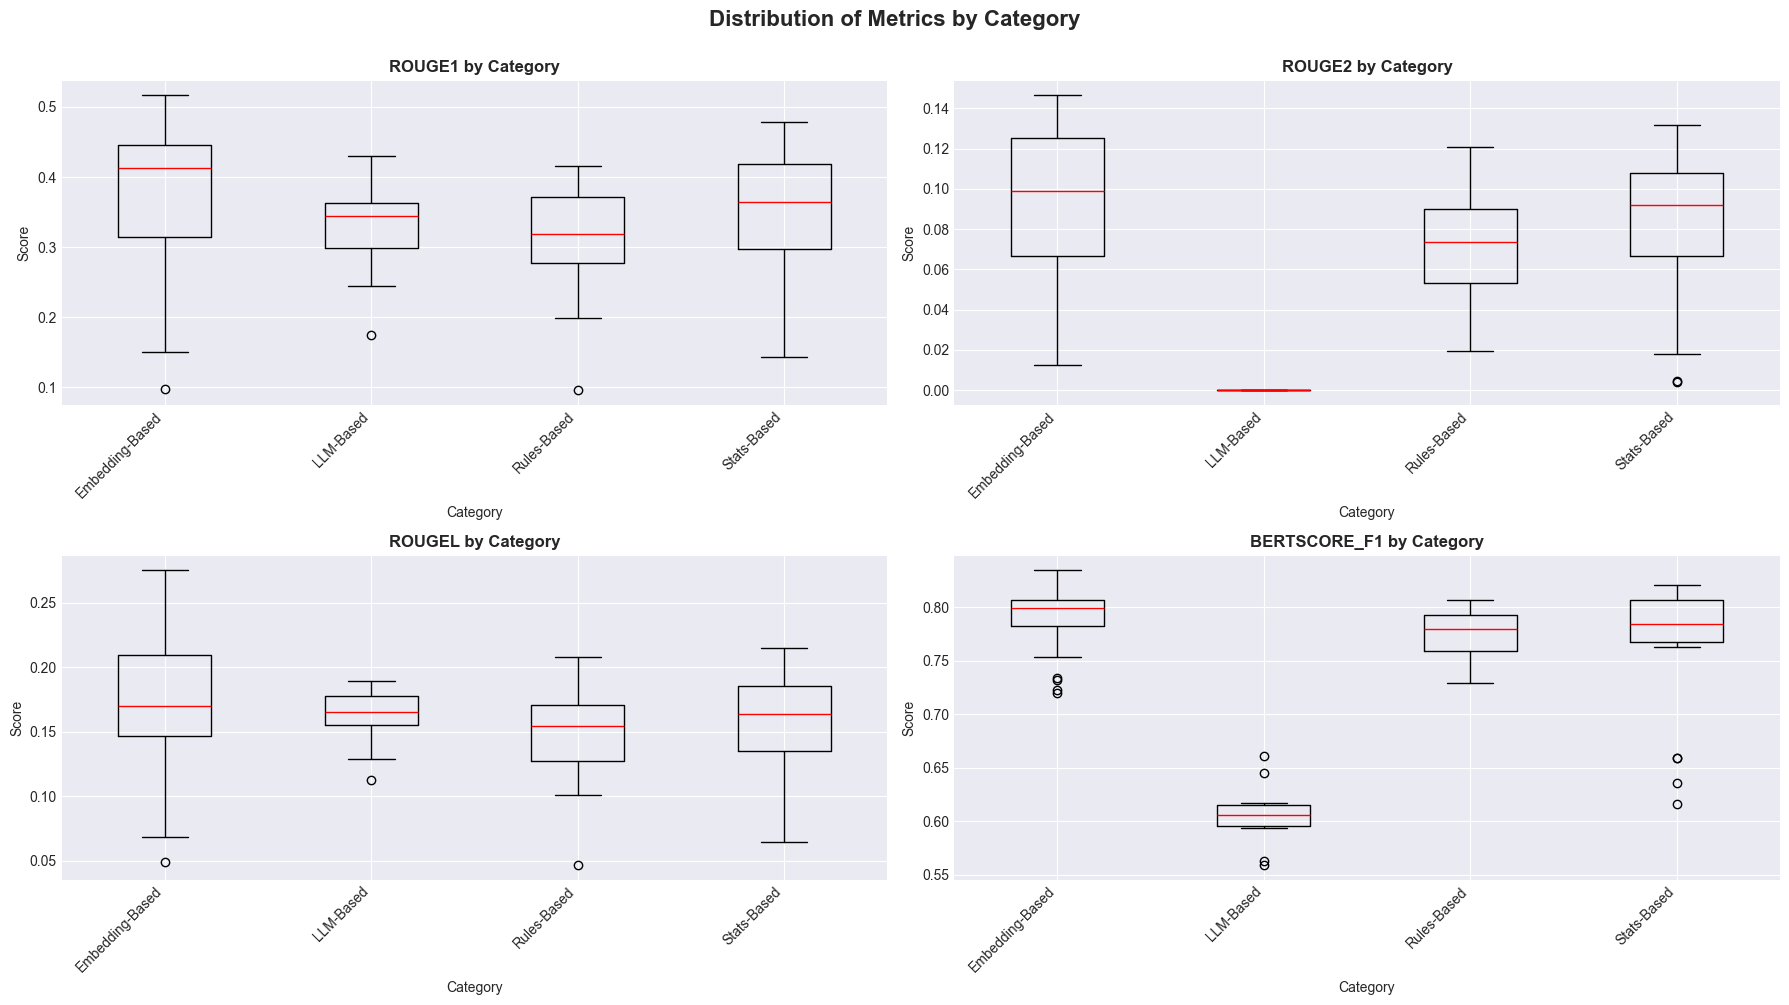

In [11]:
# Box plots for each metric
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    df_consolidated.boxplot(
        column=metric, 
        by='category', 
        ax=ax,
        boxprops=dict(color='black'),
        medianprops=dict(color='red'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black')
        )
    ax.set_title(f'{metric.upper()} by Category', fontsize=12, fontweight='bold')
    ax.set_xlabel('Category', fontsize=10)
    ax.set_ylabel('Score', fontsize=10)
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')

# Remove the last empty subplot
# fig.delaxes(axes[5])

plt.suptitle('Distribution of Metrics by Category', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Observations:
- Embedding-Based: Consistently highest medians but more outliers, suggesting occasional failures
- Stats-Based: Remarkably consistent performance with tight distributions across all metrics
- Rules-Based: Stable performance with slightly wider variance
- LLM-Based: Bimodal behavior - competitive on ROUGE-1/L but poor on ROUGE-2 and BERTScore
- The presence of low outliers across all categories indicates that certain papers are consistently challenging regardless of the method

##### Stats-Based and Rules-based approaches show consistency and can be more reliable for Production Use despite slightly lower peak performance.

## 5. Ranking Analysis


OVERALL BASELINE RANKINGS (by average score across all metrics)
               baseline  average_score
0  Embedding-Gemini-2.5         0.3726
1   Embedding-Llama-3.1         0.3651
2                TF-IDF         0.3508
3     Lead-N-By-Section         0.3412
4         Embedding-LED         0.3388
5                  BM25         0.3194
6                Lead-N         0.3137
7         LLM-Gemma3-1B         0.2735


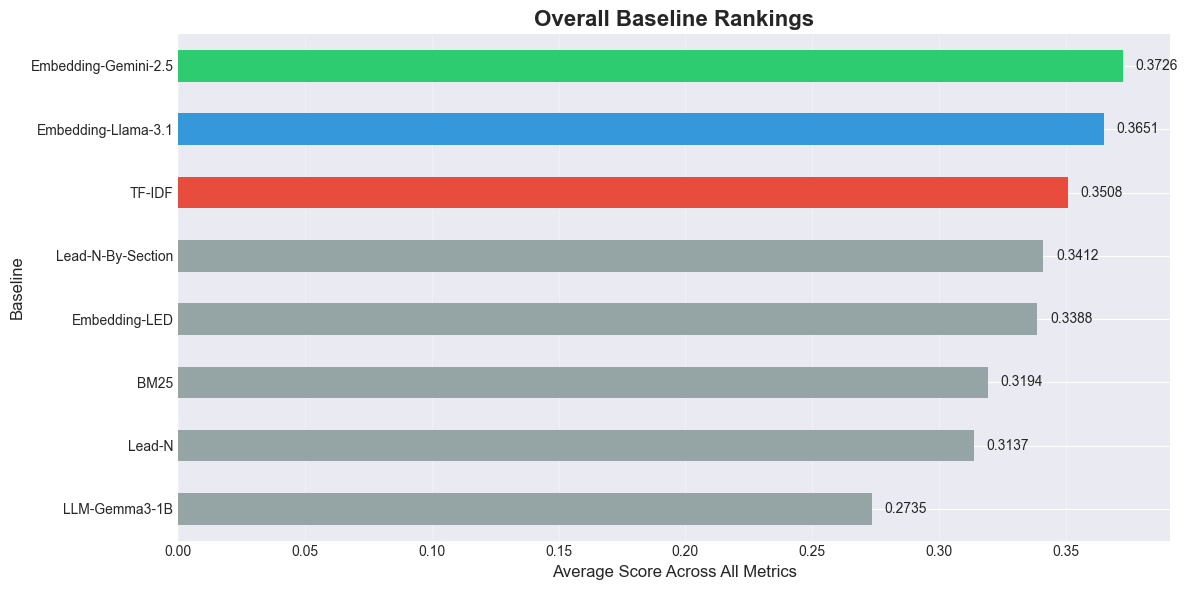

In [14]:
# Calculate overall ranking based on average across all metrics
baseline_rankings = df_consolidated.groupby('baseline')[metrics].mean()
baseline_rankings['average_score'] = baseline_rankings.mean(axis=1)
baseline_rankings = baseline_rankings.sort_values('average_score', ascending=False)

print("\n" + "="*80)
print("OVERALL BASELINE RANKINGS (by average score across all metrics)")
print("="*80)
print(baseline_rankings[['average_score']].reset_index())

# Visualize rankings
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#2ecc71' if i == 0 else '#3498db' if i == 1 else '#e74c3c' if i == 2 else '#95a5a6' 
          for i in range(len(baseline_rankings))]
baseline_rankings['average_score'].plot(kind='barh', ax=ax, color=colors)
ax.set_title('Overall Baseline Rankings', fontsize=16, fontweight='bold')
ax.set_xlabel('Average Score Across All Metrics', fontsize=12)
ax.set_ylabel('Baseline', fontsize=12)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(baseline_rankings['average_score']):
    ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 6. Category-wise Comparison

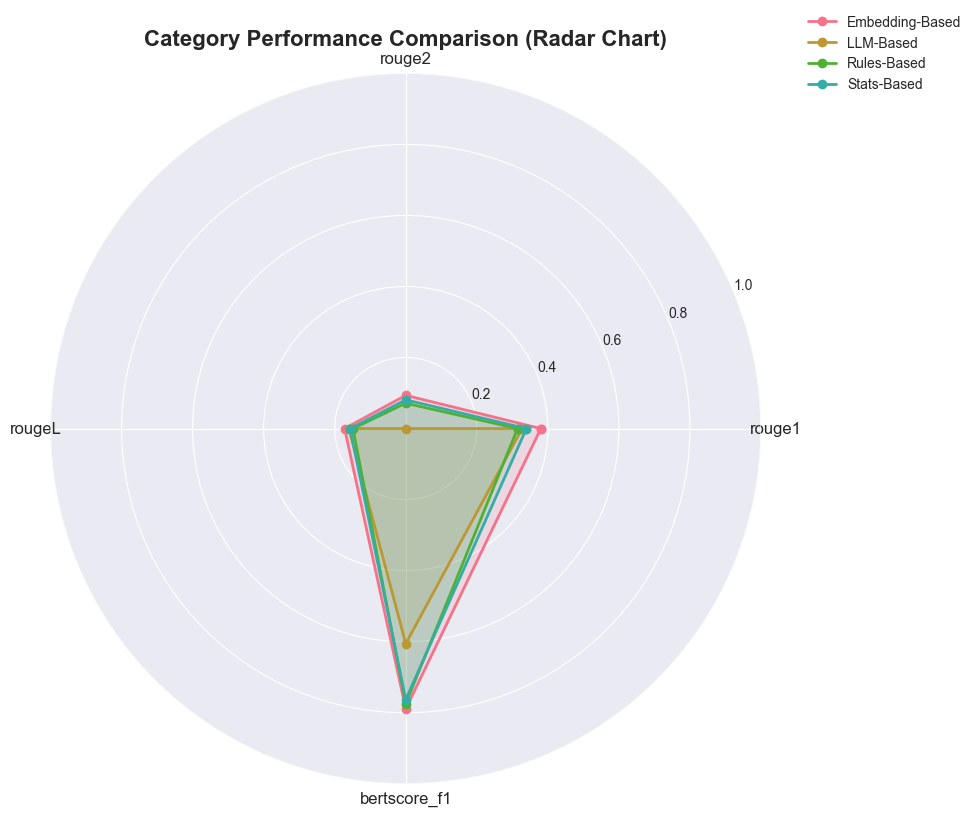

In [15]:
# Compare categories using radar charts
from math import pi

category_means = df_consolidated.groupby('category')[metrics].mean()

# Number of variables
categories = list(category_means.index)
N = len(metrics)

# Angle of each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Create radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

for category in categories:
    values = category_means.loc[category].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=category)
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, size=12)
ax.set_ylim(0, 1)
ax.set_title('Category Performance Comparison (Radar Chart)', 
             size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

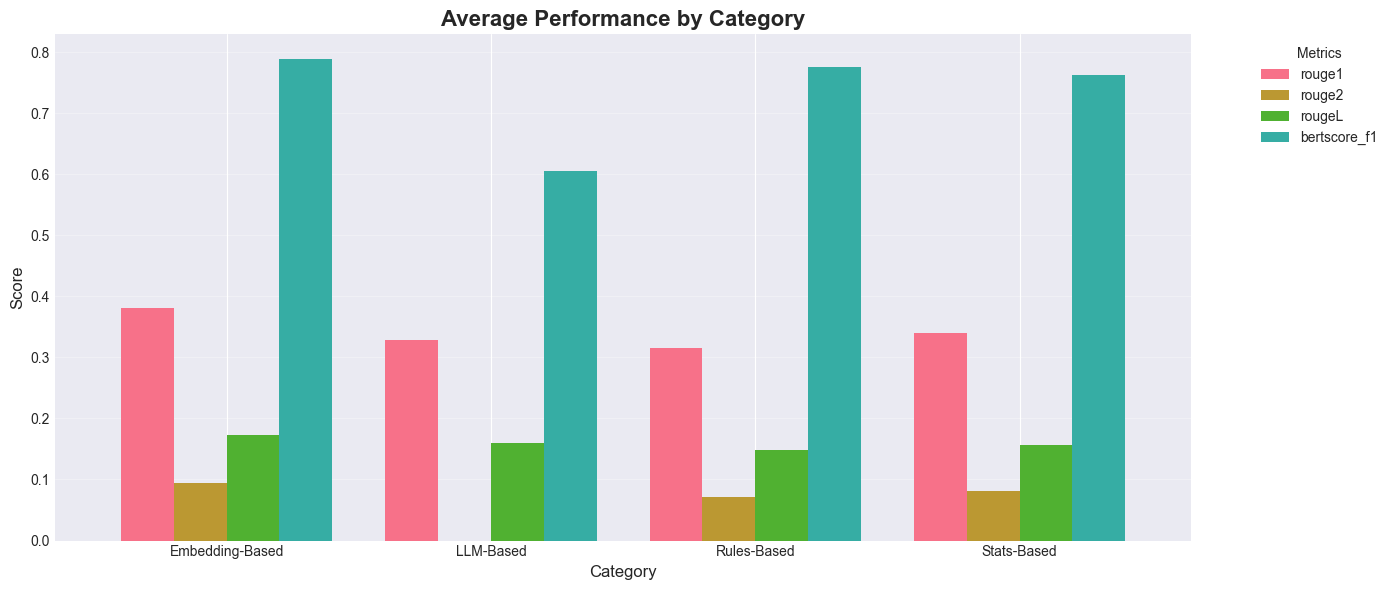

In [16]:
# Category comparison - grouped bar chart
category_comparison = df_consolidated.groupby('category')[metrics].mean()

fig, ax = plt.subplots(figsize=(14, 6))
category_comparison.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Average Performance by Category', fontsize=16, fontweight='bold')
ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Conclusion
This analysis shows us distinctive performance characteristics across 4 categories. Embedding based approaches achieve highest scores but exhibit greater variance, while stats-based methods demonstrate a really good consistent performance.

The universal pattern of high BERTScore with low ROUGE scores indicates that all methods somewhat manage to represent the paper but the wording is different than the abstract: 
- whether it be rule-based or stats-based approach, both consist content from the actual paper without any changes so it would still represent the paper somehow but will not use the same wording as the abstract 
- whereas, the llm based approaches (embedding based approaches included) summarizes the paper better than other approaches but also use different wording than abstract as it is a generative approach.

Rules-based approaches perform competitively despite their simplicity, while the llm-based and embedding based approaches underperform despite their complexity.

The presence of outliers across all categories suggests that certain papers remain inherently challenging regardless of the approach, highlighting the complexity of academic text summarization.